In [6]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
import time
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
import requests

#dont keep api key in github!!!
api_file = os.path.join('..','..','..','apikeys','steam_api_key.txt')
with open(api_file, 'r') as fin:
    api = WebAPI(key=fin.readline())

#tf.logging.set_verbosity(tf.logging.ERROR)

In [7]:
#declare interface urls
#dota2_beta should be used for testing in order to not aggressively make API requests
dota2_id = '570'
dota2_beta_id = '205790'

hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes',itemizedonly = True)
hero_vocab=[int(hero_id['id']) for hero_id in hero_list['result']['heroes']] 

# Import training data and preprocess 
(good to check data, but not needed for TFrecord usage

In [ ]:
dota2_df = None
for filename in glob.glob(os.path.join('dota2_training_data','*.csv')):
    if type(dota2_df)==None:
        dota2_df = pd.read_csv(filename, usecols=range(1,13))
    else:
        dota2_df = pd.concat([dota2_df, pd.read_csv(filename, usecols=range(1,13))],ignore_index=True)

dota2_df = dota2_df.reindex(np.random.permutation(dota2_df.index))
dota2_df.describe()


# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline

In [8]:
def _parse_function(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "dire_heroes": tf.FixedLenFeature([], dtype=tf.string), #array of five 8-bit ints for heroes
        "targets": tf.FixedLenFeature(shape=[1], dtype=tf.int64)
                }
  
    parsed_features = tf.parse_single_example(record, features)
  
    radiant_heroes = tf.decode_raw(parsed_features['radiant_heroes'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['dire_heroes'], tf.int64)
    radiant_win = parsed_features['targets']

    return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes}, radiant_win

#### Check the parse function worked

In [9]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('Dota_data',
                                          'mixed_skill',
                                          'dota2_training_data',
                                          'radiant_windota2_training_data.tfrecords'),
                             compression_type="GZIP")
# Map features and labels with the parse function.
ds = ds.map(_parse_function)
ds

AttributeError: in converted code:

    <ipython-input-8-becd7bc26350>:11 _parse_function  *
        features = {

    AttributeError: module 'tensorflow' has no attribute 'FixedLenFeature'


In [5]:
ds = ds.shuffle(10000)
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'radiant_heroes': array([ 21, 105,  69,  12,  59]),
  'dire_heroes': array([ 42,  67,  64, 112,  22])},
 array([1]))

## Model Functions

In [6]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(batch_size, ds.output_shapes)
  
    ds = ds.repeat(num_epochs)
  
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Linear model with explicit vocabulary (all heroes)

In [4]:
def construct_hero_categorical_columns(keys, vocab):
    """Construct categorical features for all features
        Args: 
            input_features: names of input feature columns to use
        returns:
            a set of categorical columns
    """
    return set([tf.feature_column.categorical_column_with_vocabulary_list(key,
                                                                     vocabulary_list = vocab,
                                                                     num_oov_buckets =0)
                                    for key in keys])
                                                               

## Define and train the linear model

In [2]:
def train_linear_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_file,
    validation_file,
    compression_type):
    """Trains a linear regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: A `int` specifying the number of examples for each training step.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `LinearClassifier` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.keras.optimizers.AdamOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.clip_by_global_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
      )
       
    training_input_fn =lambda: _input_fn([training_file], 
                                         batch_size=batch_size,
                                         compression_type=compression_type)
    validation_input_fn =lambda: _input_fn([validation_file], 
                                           batch_size=batch_size,
                                          compression_type=compression_type)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_loss = []
    validation_loss = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = linear_classifier.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_loss.append(evaluation_metrics['loss'])
                            
        evaluation_metrics = linear_classifier.evaluate(
            input_fn=validation_input_fn,
            steps=steps_per_period)    
        validation_loss.append(evaluation_metrics['loss'])
        
        print('validation loss', evaluation_metrics['loss'])

    #save trained model
    serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
                          tf.feature_column.make_parse_example_spec(feature_columns))
    export_path = linear_classifier.export_saved_model(
                            os.path.join('trained_models','LIN','_lr'+str(learning_rate)
                        +'_s'+str(steps)+'_bs'+str(batch_size)), serving_input_fn)
    
    print('model saved at:/trained_models/LIN/'+'_lr'+str(learning_rate)+'_s'+str(steps)
          +'_bs'+str(batch_size)+'/'+str(int(time.time())))
    
    print("validation set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_loss,label='Training loss')
    plt.plot(validation_loss,label='validation loss')
    plt.legend()
    plt.show()
    
    return linear_classifier


In [5]:
training_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_windota2_training_data.tfrecords')
validation_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_windota2_validation_data.tfrecords')

categorical_column = construct_hero_categorical_columns(['radiant_heroes','dire_heroes'],
                                                       hero_vocab)

NameError: name 'hero_vocab' is not defined

In [ ]:
trained_linear_model = train_linear_model(
    learning_rate=0.0005,
    steps=5e2,
    batch_size=50000,
    feature_columns=categorical_column,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

In [ ]:
trained_linear_model = train_linear_model(
    learning_rate=0.0005,
    steps=5e3,
    batch_size=500,
    feature_columns=categorical_column,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

In [14]:
trained_linear_model = train_linear_model(
    learning_rate=0.0005,
    steps=1e3,
    batch_size=5000,
    feature_columns=categorical_column,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3292.8647
validation loss 3276.0032
validation loss 3263.6008
validation loss 3254.011
validation loss 3246.0986
validation loss 3240.1853
validation loss 3235.2515
validation loss 3231.118
validation loss 3228.544
validation loss 3225.809
validation loss 3223.9858
validation loss 3222.9907
validation loss 3221.444
validation loss 3220.4453
validation loss 3219.9316
validation loss 3218.7185
validation loss 3218.3728
validation loss 3218.7144
validation loss 3217.608
validation loss 3218.0156


TypeError: int() argument must be a string, a bytes-like object or a number, not 'builtin_function_or_method'

Training model...
validation loss 3.4621856
validation loss 3.4657173
validation loss 3.462072
validation loss 3.4669216
validation loss 3.4687839
validation loss 3.4662185
validation loss 3.473226
validation loss 3.4621956
validation loss 3.4705539
validation loss 3.4740443
validation loss 3.463873
validation loss 3.4668689
validation loss 3.4597237
validation loss 3.4599013
validation loss 3.463157
validation loss 3.485374
validation loss 3.4614635
validation loss 3.461827
validation loss 3.4465537
validation loss 3.4830658
model saved at:/trained_models/LIN/_lr0.0005_s100.0_bs5/1570662220
validation set metrics:
accuracy 0.36
accuracy_baseline 0.68
auc 0.60294116
auc_precision_recall 0.4613636
average_loss 0.69661313
label/mean 0.32
loss 3.4830658
precision 0.33333334
prediction/mean 0.50580096
recall 1.0
global_step 100
---


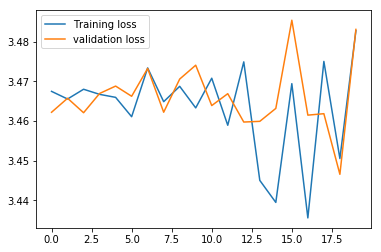

In [16]:
trained_linear_model = train_linear_model(
    learning_rate=0.0005,
    steps=1e2,
    batch_size=5,
    feature_columns=categorical_column,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

### Evaluate linear model on test set 
Don't do this until you're done tuning hyperparams!!

In [17]:
test_file = os.path.join('dota2_test_data', 'dota2_test_data.tfrecords')
test_input_fn =lambda: _input_fn([test_file])
evaluation_metrics = trained_linear_model.evaluate(
            input_fn=test_input_fn,
            steps=100)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

accuracy 0.5852
accuracy_baseline 0.5486
auc 0.6071559
auc_precision_recall 0.6377059
average_loss 0.67106634
label/mean 0.5486
loss 33.553318
precision 0.59609306
prediction/mean 0.5435795
recall 0.75647104
global_step 1000000


## Define and train a DNN model

### Define feature column constructor functions

In [39]:
def construct_indicator_columns(feature_columns):
    """Construct indicator columns for all features
            from categorical columns
        Args: 
            feature_columns: Set of 'tf.feature_column.categorical_column'
                to convert to indicator columns
        returns:
            a list of indicator columns
    """
    indicator_columns = []
    for column in list(feature_columns):
        indicator_columns.append(tf.feature_column.indicator_column(column))
        
    return indicator_columns
        

In [40]:
def construct_embedding_columns(feature_columns, dimension):
    """Construct embedding columns for all features
            from categorical columns
        Args:
            feature_columns: `Set` of 'tf.feature_column.categorical_column'
                to convert to embedding columns
            dimension: `int` that shows the 
        returns:
            a list of embedding columns
    """
            
    embedding_columns = []
    for column in list(feature_columns):
        embedding_columns.append(tf.feature_column.embedding_column(column,dimension=dimension))
        
    return embedding_columns

### Define model training function

In [ ]:
def train_dnn_model(
    learning_rate,
    weight_decay,
    hidden_units,
    steps,
    batch_size,
    feature_columns,
    training_file,
    validation_file,
    compression_type):
    """Trains a deep neural network regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        weight_decay: A `float`, the weight decay for the AdamW optimizer
        learning_rate: A `float`, the learning rate.
        hidden_units: A `list` of `ints` specifying the number of layers and number 
            of nodes per layer.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `DNNClassifer` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods

    # Create a dnn regressor object.
    my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=weight_decay,
                                                 learning_rate=learning_rate)
    dnn_classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      hidden_units=hidden_units,
      optimizer=my_optimizer
      )
  
    training_input_fn =lambda: _input_fn([training_file],batch_size=batch_size,
                                         compression_type=compression_type)
    validation_input_fn =lambda: _input_fn([validation_file],batch_size=batch_size,
                                    compression_type=compression_type)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_loss = []
    validation_loss = []
    training_acc = []
    validation_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        dnn_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = dnn_classifier.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_loss.append(evaluation_metrics['loss'])
        training_acc.append(evaluation_metrics['accuracy'])
        
        evaluation_metrics = dnn_classifier.evaluate(
            input_fn=validation_input_fn,
            steps=steps_per_period)    
        validation_loss.append(evaluation_metrics['loss'])
        validation_acc.append(evaluation_metrics['accuracy'])
        print('validation loss', evaluation_metrics['loss'])
    datetime=now.strftime('%Y%m%d_%H%M')
    serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
                          tf.feature_column.make_parse_example_spec(feature_columns))
    export_path = linear_classifier.export_saved_model(
                        os.path.join('trained_models','DNN',+datetime+'_lr'+str(learning_rate)+'_wd'
                        +str(weight_decay)+'_s'+str(steps)+'_bs'+str(batch_size)),
                        serving_input_fn)
    
    print('model saved at:/trained_models/DNN/'+datetime
          +'_lr'+str(learning_rate)+'_wd'+str(weight_decay)+
          '_s'+str(steps)+'_bs'+str(batch_size))
    
    print("validation set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_loss,label='Training loss')
    plt.plot(validation_loss,label='validation loss')
    plt.legend()
    plt.show()
    
    plt.plot(training_acc,label='Training accuracy')
    plt.plot(validation_acc,label='validation accuracy')
    plt.legend()
    plt.show()
    return dnn_classifier


### Specify path to tfrecord files and construct feature colums

In [59]:
training_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_windota2_training_data.tfrecords')
validation_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_windota2_validation_data.tfrecords')

categorical_feature_columns = construct_hero_categorical_columns(['radiant_heroes','dire_heroes'],
                                                       hero_vocab)
indicator_feature_columns = construct_indicator_columns(categorical_feature_columns)

embed_dim = 4
embedding_feature_columns = construct_embedding_columns(categorical_feature_columns,dimension=embed_dim)

### Train model

Training model...
validation loss 3327.641
validation loss 3325.7258
validation loss 3321.6174
validation loss 3318.9692
validation loss 3315.723
validation loss 3309.3757
validation loss 3303.0242
validation loss 3295.6978
validation loss 3287.4314
validation loss 3280.6794
validation loss 3275.186
validation loss 3270.7642
validation loss 3263.982
validation loss 3261.4634
validation loss 3255.719
validation loss 3252.8638
validation loss 3252.22
validation loss 3250.519
validation loss 3249.7432
validation loss 3245.5493
validation set metrics:
accuracy 0.58229405
accuracy_baseline 0.5481486
auc 0.6042861
auc_precision_recall 0.6364126
average_loss 0.6716412
label/mean 0.5481486
loss 3245.5493
precision 0.5964973
prediction/mean 0.5469724
recall 0.7355029
global_step 300
---


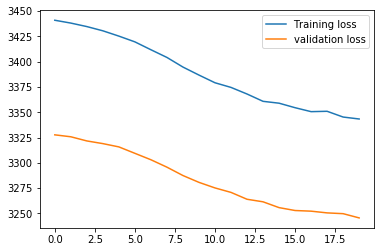

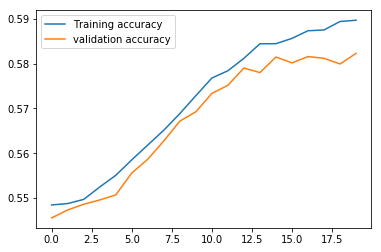

In [61]:
dnn_rate = .0025
dnn_decay = .0004
dnn_hidden_units = [10,10]
dnn_steps = 3e2
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    learning_rate = dnn_rate,
    weight_decay = dnn_decay,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3297.456
validation loss 3280.8757
validation loss 3258.37
validation loss 3237.0059
validation loss 3225.048
validation loss 3221.1755
validation loss 3219.4866
validation loss 3219.2463
validation loss 3218.4368
validation loss 3219.0356
validation loss 3218.906
validation loss 3219.1782
validation loss 3218.4846
validation loss 3218.8953
validation loss 3218.7937
validation loss 3218.7478
validation loss 3218.7998
validation loss 3218.762
validation loss 3218.9148
validation loss 3219.5457
validation set metrics:
accuracy 0.5832722
accuracy_baseline 0.548092
auc 0.6065697
auc_precision_recall 0.6391052
average_loss 0.6709176
label/mean 0.548092
loss 3219.5457
precision 0.5916767
prediction/mean 0.55537164
recall 0.77342653
global_step 1000
---


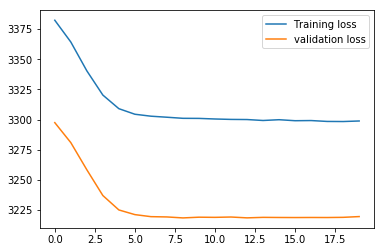

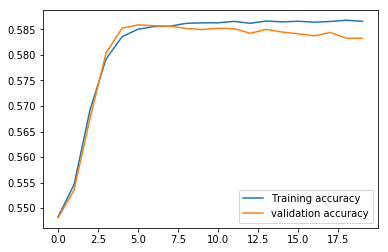

In [62]:
dnn_rate = .0025
dnn_decay = .0004
dnn_hidden_units = [10,10]
dnn_steps = 1e3
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    learning_rate = dnn_rate,
    weight_decay = dnn_decay,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3325.7344
validation loss 3321.0437
validation loss 3315.7424
validation loss 3311.3936
validation loss 3304.9092
validation loss 3295.9954
validation loss 3289.886
validation loss 3281.6875
validation loss 3273.0942
validation loss 3269.242
validation loss 3261.5288
validation loss 3259.5437
validation loss 3255.154
validation loss 3251.03
validation loss 3250.6794
validation loss 3249.2625
validation loss 3248.1497
validation loss 3249.3716
validation loss 3248.1157
validation loss 3248.7283
validation set metrics:
accuracy 0.58138347
accuracy_baseline 0.5464792
auc 0.60373175
auc_precision_recall 0.6348101
average_loss 0.6722991
label/mean 0.5464792
loss 3248.7283
precision 0.5932357
prediction/mean 0.5513915
recall 0.74436396
global_step 300
---


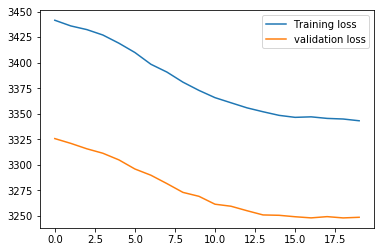

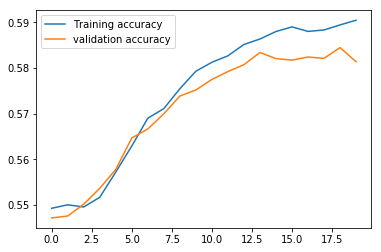

In [63]:

dnn_rate = .0025
dnn_decay = .0002
dnn_hidden_units = [10,10]
dnn_steps = 3e2
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    learning_rate = dnn_rate,
    weight_decay = dnn_decay,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3293.7053
validation loss 3270.2385
validation loss 3245.7195
validation loss 3231.3179
validation loss 3223.3096
validation loss 3220.7546
validation loss 3218.8357
validation loss 3218.7522
validation loss 3218.6287
validation loss 3218.061
validation loss 3218.2458
validation loss 3218.2407
validation loss 3218.483
validation loss 3217.9312
validation loss 3218.946
validation loss 3218.51
validation loss 3219.2146
validation loss 3218.8223
validation loss 3218.2876
validation loss 3218.6855
validation set metrics:
accuracy 0.5823136
accuracy_baseline 0.54832536
auc 0.6067864
auc_precision_recall 0.6403034
average_loss 0.67073834
label/mean 0.54832536
loss 3218.6855
precision 0.5928207
prediction/mean 0.5522002
recall 0.7608218
global_step 1000
---


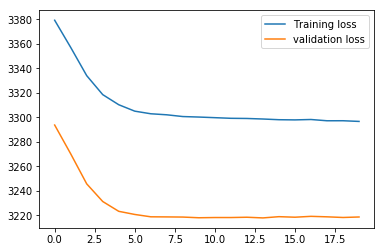

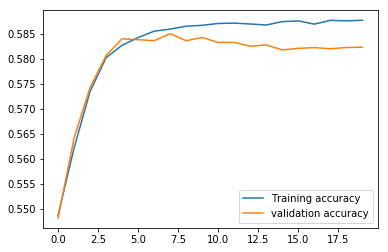

In [64]:
dnn_rate = .0025
dnn_decay = .0002
dnn_hidden_units = [10,10]
dnn_steps = 1e3
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    learning_rate = dnn_rate,
    weight_decay = dnn_decay,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3251.7266
validation loss 3223.915
validation loss 3221.9758
validation loss 3220.8447
validation loss 3222.183
validation loss 3223.73
validation loss 3221.8647
validation loss 3221.554
validation loss 3222.32
validation loss 3221.3223
validation loss 3224.7336
validation loss 3225.703
validation loss 3225.2725
validation loss 3225.4353
validation loss 3226.5378
validation loss 3226.2385
validation loss 3230.9417
validation loss 3227.3503
validation loss 3226.9941
validation loss 3228.2788
validation set metrics:
accuracy 0.5808882
accuracy_baseline 0.54813784
auc 0.6002308
auc_precision_recall 0.635291
average_loss 0.6727375
label/mean 0.54813784
loss 3228.2788
precision 0.59452593
prediction/mean 0.54237974
recall 0.7402485
global_step 500
---


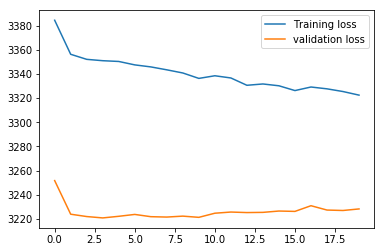

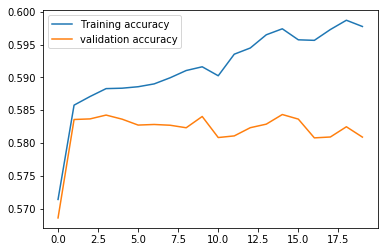

In [65]:
dnn_rate = .025
dnn_decay = .002
dnn_hidden_units = [10,10]
dnn_steps = 5e2
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    learning_rate = dnn_rate,
    weight_decay = dnn_decay,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3441.5679
validation loss 3437.0718
validation loss 3426.1187
validation loss 3410.9634
validation loss 3401.7234
validation loss 3393.8418
validation loss 3382.7864
validation loss 3379.3618
validation loss 3374.23
validation loss 3375.7234
validation loss 3380.3079
validation loss 3381.899
validation loss 3383.4849
validation loss 3389.8657
validation loss 3387.1245
validation loss 3391.8472
validation loss 3397.6504
validation loss 3399.2202
validation loss 3406.188
validation loss 3400.4622
validation set metrics:
accuracy 0.57308
accuracy_baseline 0.54788
auc 0.58627343
auc_precision_recall 0.6207758
average_loss 0.6800924
label/mean 0.54788
loss 3400.4622
precision 0.58555907
prediction/mean 0.55282444
recall 0.7554939
global_step 100
---


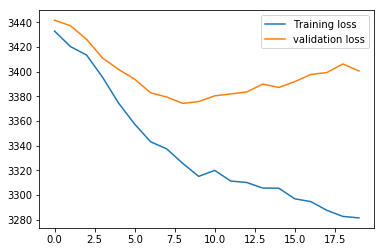

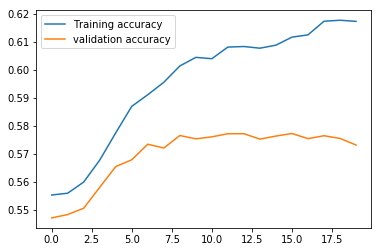

In [67]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.002, learning_rate=0.025)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

dnn_rate = .025
dnn_decay = .002
dnn_hidden_units = [10,10]
dnn_steps = 1e2
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    learning_rate = dnn_rate,
    weight_decay = dnn_decay,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

### Validate model
only do this if you're done training!!

In [10]:
validation_file = os.path.join('dota2_validation_data', 'dota2_validation_data.tfrecords')
validation_input_fn =lambda: _input_fn([validation_file])
evaluation_metrics = trained_dnn_model.evaluate(
            input_fn=validation_input_fn,
            steps=3e4)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

accuracy 0.5890347
accuracy_baseline 0.543492
auc 0.6158235
auc_precision_recall 0.64411813
average_loss 0.6686505
label/mean 0.543492
loss 33.432526
precision 0.59568346
prediction/mean 0.5534632
recall 0.75902987
global_step 30000


### Investigate embeding layer

In [79]:
hero_list = interface('IEconDOTA2_570').GetHeroes(itemizedonly = True)['result']['heroes']

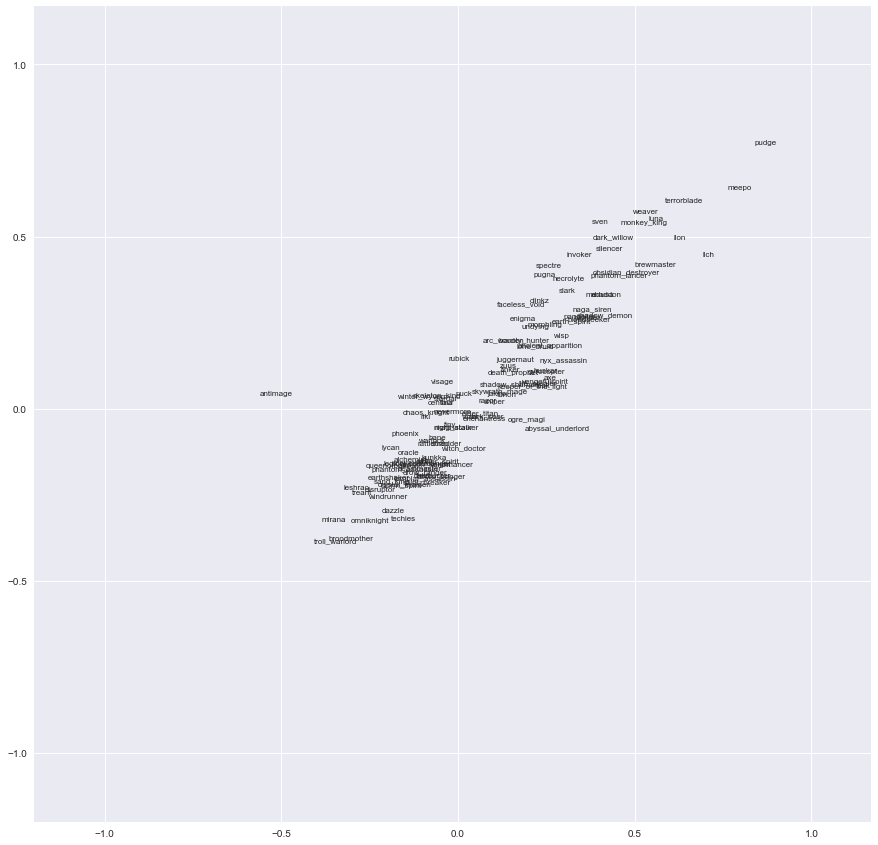

In [85]:
vocab = list(range(105))+list(range(106,114))+list(range(119,121))
dire_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/dire_heroes_embedding/embedding_weights')

radiant_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/radiant_heroes_embedding/embedding_weights')

for hero_index in range(len(vocab)):
    # Create a one-hot encoding for our term. It has 0s everywhere, except for
    # a single 1 in the coordinate that corresponds to that term.
    dire_vector = np.zeros(len(vocab))
    dire_vector[hero_index] = 1
    radiant_vector = np.zeros(len(vocab))
    radiant_vector[hero_index] = 1
    # We'll now project that one-hot vector into the embedding space.
    dire_embedding_xy = np.matmul(dire_vector, dire_embedding_matrix)
    radiant_embedding_xy = np.matmul(dire_vector,dire_embedding_matrix)
    #plt.text(dire_embedding_xy[0],
    #       dire_embedding_xy[1],
    #       hero_list[hero_index]['name'][14:],fontsize=8)
    plt.text(radiant_embedding_xy[0],
           radiant_embedding_xy[3],
           hero_list[hero_index]['name'][14:],fontsize=8,)

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * dire_embedding_matrix.min(), 1.2 * dire_embedding_matrix.max())
plt.ylim(1.2 * dire_embedding_matrix.min(), 1.2 * dire_embedding_matrix.max())
plt.show() 

### Save a trained model for later exploration, or for on-demand prediction of test cases

In [103]:
def serving_input_receiver_fn():
    """An input receiver that expects a serialized tf.Example."""
    feature_spec = {
        "radiant_heroes": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "dire_heroes": tf.FixedLenFeature([], dtype=tf.string) #array of five 8-bit ints for heroes
                }
    serialized_tf_example = tf.placeholder(dtype=tf.string,
                                         shape=[1],
                                         name='input_example_tensor')
    receiver_tensors = {'examples': serialized_tf_example}
    parsed_features = tf.parse_example(serialized_tf_example, feature_spec)
    
    radiant_heroes = tf.decode_raw(parsed_features['radiant_heroes'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['dire_heroes'], tf.int64)
    
    features = {'radiant_heroes':radiant_heroes, 'dire_heroes': dire_heroes}
    
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [104]:
export_dir = os.path.join('trained_models','dnn_models')
trained_dnn_model.export_savedmodel(
                                export_dir_base = export_dir,
                                serving_input_receiver_fn = serving_input_receiver_fn)

b'trained_models/dnn_models/1563329122'

In [105]:
export_dir = os.path.join('trained_models','linear_models')
trained_linear_model.export_savedmodel(
                                export_dir_base = export_dir,
                                serving_input_receiver_fn = serving_input_receiver_fn)

b'trained_models/linear_models/1563329152'

# Preprocessing, input functions, and linear training for DataFrame data format

## Preprocess functions for input without TFRecords format

In [46]:
#Split training and validation datasets with a given training fraction. 

#to begin with we have a sample of 7050 matches to validation the model with.
#This may not be enough games to accurately determine win probability but probably good enough for first validations

training_fraction = 0.7
head_num = int(training_fraction * len(dota2_df))
tail_num = len(dota2_df)-head_num

training_examples = preprocess_features(dota2_df.head(head_num))
training_targets = preprocess_targets(dota2_df.head(head_num))

validation_examples = preprocess_features(dota2_df.tail(tail_num))
validation_targets = preprocess_targets(dota2_df.tail(tail_num))

#print("Training features summary")
#training_examples.style
print("\nTraining targets summary")
display.display(training_targets.describe())

#print("\nvalidation feature summary")
#validation_examples.style
print("\nvalidation target summary")
display.display(validation_targets.describe())


Training targets summary


,radiant_win
count,6157.000000
mean,0.549943
std,0.497540
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000



validation target summary


,radiant_win
count,2640.000000
mean,0.549242
std,0.497664
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [3]:
def preprocess_features(dota2_df):
    """Take dota2_df and create a dataframe containing only the features for our model
            Args: 
                dota2_df: Dataframe containing dota2 training and test data
            returns: 
                processed_df: pandas DataFrame containing only feature columns
    """
    
    #Use arrays of heroes for each team as features rather than each hero
    #individually to help model fit?
    #This is an attempt to make the model more similar to the movie review
    #text analysis example in the Google ML Crash Course
    processed_df = pd.DataFrame()
    
    processed_df['radiant_heroes'] = list(np.array(dota2_df.loc[:,['radiant_heroes0',
                                                'radiant_heroes1','radiant_heroes2',
                                                'radiant_heroes3','radiant_heroes4']]))
    processed_df['dire_heroes'] = list(np.array(dota2_df.loc[:,['dire_heroes0',
                                    'dire_heroes1','dire_heroes2',
                                    'dire_heroes3','dire_heroes4']]))
    
    ##only features (to start with) are the heroes in the game
    #processed_df = dota2_df[['radiant_heroes0', 'radiant_heroes1',
    #                   'radiant_heroes2', 'radiant_heroes3', 'radiant_heroes4',
    #                    'dire_heroes0', 'dire_heroes1', 'dire_heroes2',
    #                    'dire_heroes3', 'dire_heroes4']]
    
    ##create two synthetic features that is the product of all heroes for each team
    #processed_df['radiant_hero_product'] = dota2_df['radiant_heroes0']*dota2_df['radiant_heroes1']*dota2_df['radiant_heroes2']dota2_df['radiant_heroes3']*dota2_df['radiant_heroes4']
    #processed_df['dire_hero_product'] = dota2_df['dire_heroes0']*dota2_df['dire_heroes1']*dota2_df['dire_heroes2']dota2_df['dire_heroes3']*dota2_df['dire_heroes4']
    
    return processed_df
    
def preprocess_targets(dota2_df):
    """Take dota2_df and create a dataframe containing only the targets for our model
            Args: 
                dota2_df: Dataframe containing dota2 training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column
    """
    target_df = pd.DataFrame()
    target_df['radiant_win'] = dota2_df['radiant_win']
    
    return target_df

## Build Functions for doing linear classifier modelling without TFRecords

In [77]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a logistic regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = tf.data.Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### DNN model training 

In [86]:
def train_dnn_model(
    learning_rate,
    regularization,
    hidden_units,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets):
    """Trains a deep neural network regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        l1_regularization: A `float`, the L1 regularization rate. This regularizatin 
          penalizes non-zero weights in the model to prevent overfitting as well as
          save memory.
        l2_regularization: A `float`, the L2 regularization rate. This regularization
          penalizes large weights in the model to prevent overfitting.
        hidden_units: A list of `ints`, the number of nodes in each layer for the DNN
          model.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `DNNClassifer` object trained on the training data.
    """

    periods = 10
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      hidden_units=hidden_units,
      optimizer=my_optimizer
      )
  
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["radiant_win"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["radiant_win"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        dnn_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
            )
        # Take a break and compute predictions.
        training_predictions = dnn_classifier.predict(input_fn=predict_training_input_fn)
    
    print("Model training finished.")


    return dnn_classifier

In [ ]:
trained_linear_model = train_dnn_model(
    learning_rate=0.07,
    regularization=0.01
    steps=1000,
    batch_size=100,
    feature_columns=construct_hero_categorical_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets)